In [34]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [19]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [3]:
!git clone https://github.com/balajisrinivas/Face-Mask-Detection.git

Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 3764, done.
remote: Total 3764 (delta 0), reused 0 (delta 0), pack-reused 3764
Receiving objects: 100% (3764/3764), 143.05 MiB | 38.53 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [23]:
DIRECTORY ="/content/Face-Mask-Detection/dataset"

In [24]:
CATEGORIES = ["with_mask", "without_mask"]

In [26]:
data = []
labels = []

In [27]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [28]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [52]:
print(data.shape)
print(labels.shape)

(3833, 224, 224, 3)
(3833, 2)


In [29]:
(X_train, X_test, y_train, y_test) = train_test_split(data, labels,test_size=0.30, stratify=labels, random_state=0)
#if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, 
#(stratify=y) will make sure that your random split has 25% of 0's and 75% of 1's.

In [30]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

#eg. When your image shift by 20% there is some space left over."nearest" will fill the area with the nearest pixel and stretching it.

In [31]:
# load the MobileNetV2 network, ensuring the head FC layer sets are

baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [43]:
baseModel.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>

In [41]:
baseModel.output

<KerasTensor: shape=(None, 7, 7, 1280) dtype=float32 (created by layer 'out_relu')>

In [35]:
# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = MaxPooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [44]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [45]:
# loop over all layers in the base model and freeze them so they will not  be trained again
for layer in baseModel.layers:
	layer.trainable = False

In [46]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [51]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2683, 224, 224, 3)
(2683, 2)
(1150, 224, 224, 3)
(1150, 2)


In [47]:
# train the head of the network
print("[INFO] training head...")
model_head = model.fit(
	aug.flow(X_train, y_train, batch_size=BS),
	steps_per_epoch=len(X_train) // BS,   #no of steps like here 83
	validation_data=(X_test, y_test),
	validation_steps=len(X_test) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/10
83/83 [==============================] - 32s 348ms/step - loss: 0.7766 - accuracy: 0.7888 - val_loss: 0.1735 - val_accuracy: 0.9452
Epoch 2/10
83/83 [==============================] - 30s 359ms/step - loss: 0.2389 - accuracy: 0.9189 - val_loss: 0.1124 - val_accuracy: 0.9661
Epoch 3/10
83/83 [==============================] - 29s 351ms/step - loss: 0.1592 - accuracy: 0.9510 - val_loss: 0.0943 - val_accuracy: 0.9678
Epoch 4/10
83/83 [==============================] - 29s 347ms/step - loss: 0.1320 - accuracy: 0.9574 - val_loss: 0.0837 - val_accuracy: 0.9713
Epoch 5/10
83/83 [==============================] - 28s 343ms/step - loss: 0.1201 - accuracy: 0.9593 - val_loss: 0.0728 - val_accuracy: 0.9765
Epoch 6/10
83/83 [==============================] - 29s 343ms/step - loss: 0.1052 - accuracy: 0.9676 - val_loss: 0.0673 - val_accuracy: 0.9783
Epoch 7/10
83/83 [==============================] - 29s 346ms/step - loss: 0.1081 - accuracy: 0.9657 - val_loss: 0.063

In [75]:
# make predictions on the testing set
y_pred = model.predict(X_test, batch_size=BS)

In [76]:
y_pred

array([[1.00000000e+00, 1.12342535e-08],
       [3.25875966e-08, 1.00000000e+00],
       [1.00000000e+00, 2.78852108e-10],
       ...,
       [9.99999881e-01, 1.13409996e-07],
       [6.34521075e-06, 9.99993682e-01],
       [1.16605145e-06, 9.99998808e-01]], dtype=float32)

In [77]:
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
y_pred = np.argmax(y_pred, axis=1)

In [78]:
y_pred

array([0, 1, 0, ..., 0, 1, 1])

In [66]:
from sklearn.metrics import confusion_matrix

In [81]:
cm=confusion_matrix(y_test.argmax(axis=1),y_pred)

In [82]:
cm

array([[566,   9],
       [ 13, 562]])

In [80]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test.argmax(axis=1),y_pred)

0.9808695652173913

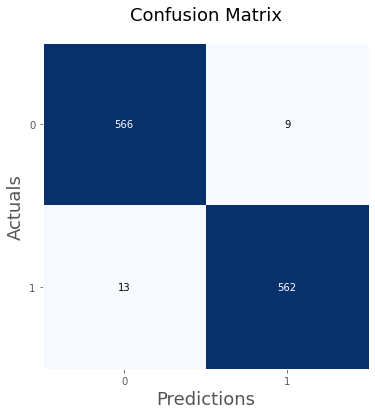

In [93]:
from mlxtend.plotting import plot_confusion_matrix
 
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


In [94]:
# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), y_pred,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.98      0.98       575
without_mask       0.98      0.98      0.98       575

    accuracy                           0.98      1150
   macro avg       0.98      0.98      0.98      1150
weighted avg       0.98      0.98      0.98      1150



In [95]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


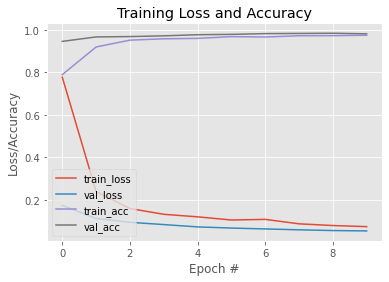

In [96]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), model_head.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), model_head.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), model_head.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), model_head.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")